## Exercise-4
Wenfeng Zhu-Computer Vision and Deep Learning: Visual Synthesis

Import the necessary libraries:

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.decomposition import PCA

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Task 1: Data Augmentation

1. **Define and train a network. Implement the following network as a torch.nn.Module module. In particular implement its __init__ and forward function:**
(a) Convolutional layer: 6 filters of size 5 × 5 with padding 0 and stride 1 + ReLU layer.
(b) Max-Pooling layer: size 2 × 2 and stride 2
(c) Convolutional layer: 16 filters of size 5×5 with padding 0 and stride 1 + ReLU layer.
(d) Max-Pooling layer: size 2 × 2 and stride 2
(e) Fully connected layer: 120 neurons + ReLU layer.
(f) Fully connected layer: 84 neurons + ReLU layer.
(g) Fully connected layer: 10 neurons.

Files already downloaded and verified
Files already downloaded and verified


Batch: 100%|██████████| 3125/3125 [00:14<00:00, 214.31it/s]



 *** Summary: Epoch [0 / 10] ***
loss: 2.6941096782684326e-05

 *** Summary: Epoch [1 / 10]  Test Accuracy: 44.85% ***


Batch: 100%|██████████| 3125/3125 [00:14<00:00, 211.69it/s]



 *** Summary: Epoch [1 / 10] ***
loss: 2.8139276504516602e-05

 *** Summary: Epoch [2 / 10]  Test Accuracy: 51.12% ***


Batch: 100%|██████████| 3125/3125 [00:14<00:00, 209.24it/s]



 *** Summary: Epoch [2 / 10] ***
loss: 2.643444538116455e-05

 *** Summary: Epoch [3 / 10]  Test Accuracy: 53.690000000000005% ***


Batch: 100%|██████████| 3125/3125 [00:14<00:00, 209.47it/s]



 *** Summary: Epoch [3 / 10] ***
loss: 2.398958683013916e-05

 *** Summary: Epoch [4 / 10]  Test Accuracy: 56.120000000000005% ***


Batch: 100%|██████████| 3125/3125 [00:14<00:00, 213.23it/s]



 *** Summary: Epoch [4 / 10] ***
loss: 2.3287644386291504e-05

 *** Summary: Epoch [5 / 10]  Test Accuracy: 57.18% ***


Batch: 100%|██████████| 3125/3125 [00:14<00:00, 214.01it/s]



 *** Summary: Epoch [5 / 10] ***
loss: 1.2993295192718506e-05

 *** Summary: Epoch [6 / 10]  Test Accuracy: 58.32000000000001% ***


Batch: 100%|██████████| 3125/3125 [00:14<00:00, 213.41it/s]



 *** Summary: Epoch [6 / 10] ***
loss: 3.519856214523315e-05

 *** Summary: Epoch [7 / 10]  Test Accuracy: 58.9% ***


Batch: 100%|██████████| 3125/3125 [00:14<00:00, 212.34it/s]



 *** Summary: Epoch [7 / 10] ***
loss: 1.798865556716919e-05

 *** Summary: Epoch [8 / 10]  Test Accuracy: 58.15% ***


Batch: 100%|██████████| 3125/3125 [00:14<00:00, 212.12it/s]



 *** Summary: Epoch [8 / 10] ***
loss: 1.7183667421340943e-05

 *** Summary: Epoch [9 / 10]  Test Accuracy: 55.82% ***


Batch: 100%|██████████| 3125/3125 [00:14<00:00, 211.83it/s]



 *** Summary: Epoch [9 / 10] ***
loss: 1.7779779434204103e-05

 *** Summary: Epoch [10 / 10]  Test Accuracy: 59.709999999999994% ***


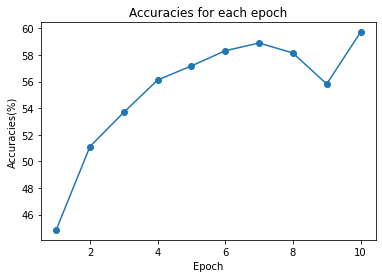

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # convolution block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5), padding=0,
                               stride=1)  # 32x32  ->  28x28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28  ->  14x14
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), padding=0, stride=1)  # 14x14  ->  10x10
        # self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1, stride=1)  # 8x8 -> 8x8
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 10x10 -> 5x5
        # fully connected block
        self.fc1 = nn.Linear(in_features=16 * 25, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # activation function
        self.rule = nn.ReLU()

    def forward(self, x):
        # conv1 layer
        out = self.rule(self.conv1(x))
        # pool layer
        out = self.pool(out)
        # conv2 layer
        out = self.rule(self.conv2(out))
        # pool2 layer
        out = self.pool2(out)
        # reshape for the first fully connected layer
        out = out.view(16, -1)
        # fc1 layer
        out = self.rule(self.fc1(out))
        # fc2 layer
        out = self.rule(self.fc2(out))
        # fc3 layer
        out = self.fc3(out)
        out = out.view(16, 10)
        return out


def load_data(transform_train, transform_test):
    trainset_base = torchvision.datasets.CIFAR10(root='../data', train=True, download=True,
                                                 transform=transform_train)
    trainloader_base = torch.utils.data.DataLoader(trainset_base, batch_size=16, shuffle=True)

    testset_base = torchvision.datasets.CIFAR10(root='../data', train=False, download=True,
                                                transform=transform_test)
    testloader_base = torch.utils.data.DataLoader(testset_base, batch_size=16, shuffle=False)

    return trainloader_base, testloader_base


def class_label(prediction):
    _, predicted_class = torch.max(prediction, 1)
    return predicted_class


def train_test(trainloader_base, testloader_base, model_name):
    net = Net()
    net.to(device)

    # define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    criterion.to(device)

    # train model
    n_epochs = 10
    best_acc = 0
    # model_name = 'base'
    # save the accuracies for each epoch in this list
    acc_per_epoch = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        net.train()
        for step, [example, label] in enumerate(tqdm(trainloader_base, desc='Batch')):
            example, label = example.to(device), label.to(device)
            # reset gradient
            optimizer.zero_grad()
            prediction = net(example)
            loss = criterion(prediction, label)
            loss.backward()
            optimizer.step()

        # evaluate
        running_loss = 0.0
        if epoch % 1 == 0:
            correct = 0
            total = 0
            print('\n *** Summary: Epoch [{} / {}] ***'.format(epoch, n_epochs))
            running_loss += loss.item()
            print('loss: {}'.format(running_loss / len(trainloader_base.dataset)))

            for idx, [test_example, test_label] in enumerate(testloader_base):
                test_example, test_label = test_example.to(device), test_label.to(device)
                net.eval()  # eval mode (matters for batchnorm layer, dropout, ...)
                with torch.no_grad():
                    test_prediction = net(test_example)
                    predicted_label = class_label(test_prediction)
                    correct += (predicted_label == test_label).sum()
                    total += test_label.size(0)

            accuracy = correct.item() / total
            acc_per_epoch.append(accuracy * 100)
            print("\n *** Summary: Epoch [{} / {}]  Test Accuracy: {}% ***".format(epoch + 1, n_epochs, accuracy * 100))
    path_save = './logging/{}'.format(model_name)
    np.save(path_save + '.npy', acc_per_epoch)
    return acc_per_epoch


def train_base():
    trainloader_base, testloader_base = load_data(transforms.ToTensor(), transforms.ToTensor())
    acc_per_epoch = train_test(trainloader_base, testloader_base, 'base')
    epochs = np.array(range(1, 11))
    plt.title("Accuracies for each epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracies(%)")
    plt.plot(epochs, acc_per_epoch)
    plt.scatter(epochs, acc_per_epoch)
    plt.show()


train_base()

2. **Input augmentation. To augment the images use random horizontal flipping and random cropping with padding=4. Also feel free to try out different augmentations, e.g. ColorJitter or GaussianBlur, different from the ones above. The augmentation is easily realized with the torchvision.transforms library. Then visualize a few pairs of augmented images against their original image.(2P)**

Files already downloaded and verified
Files already downloaded and verified
Show some comparison images:


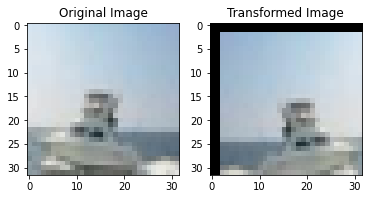

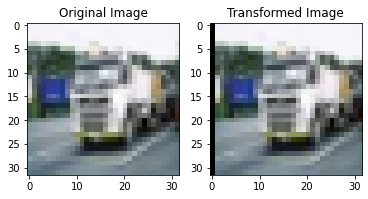

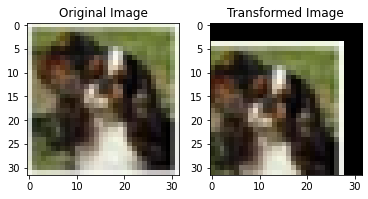

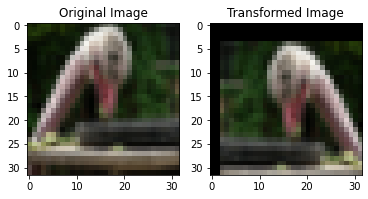

In [5]:
def show_transformed():
    transform_train = transforms.Compose([
        # extra augmentations
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(size=32, padding=4),
        transforms.ToTensor(),
        # normalization
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    transform_val = transforms.Compose([
        # extra aumentations
        transforms.GaussianBlur(kernel_size=3, sigma=0.2),
        transforms.ToTensor(),
        # normalization
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_val)
    testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)

    def against_img(index):
        img_original = trainset.data[index]
        img_transform = trainset.__getitem__(index)[0].permute(1, 2, 0)
        fig = plt.figure()
        f1 = fig.add_subplot(121)
        f2 = fig.add_subplot(122)
        f1.imshow(img_original)
        f1.title.set_text("Original Image")
        f2.imshow(img_transform)
        f2.title.set_text("Transformed Image")
        plt.show()

    print("Show some comparison images:")
    against_img(100)
    against_img(1000)
    against_img(500)
    against_img(400)
    pass


show_transformed()

3. **Train with augmentation. Train your model using the same setup, however, with additional normalization (normalize3 your input images channelwise using μ = 0.5 and σ = 0.5) and data augmentation. Train your model for 10 epochs and compare their accuracy with the result of the baseline model in sub-task 1. **

In [9]:
def train_transformed():
    transform_train = transforms.Compose([
        # extra augmentations
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(size=32, padding=4),
        transforms.ToTensor(),
        # normalization
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    transform_val = transforms.Compose([
        # extra aumentations
        transforms.GaussianBlur(kernel_size=3, sigma=0.2),
        transforms.ToTensor(),
        # normalization
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    trainloader, testloader = load_data(transform_train, transform_val)
    train_test(trainloader, testloader, 'transformed')


def train_transformed_normalize():
    transform_train = transforms.Compose([
        # extra augmentations
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(size=32, padding=4),
        transforms.ToTensor(),
        # normalization
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    transform_val = transforms.Compose([
        # extra aumentations
        transforms.GaussianBlur(kernel_size=3, sigma=0.2),
        transforms.ToTensor(),
        # normalization
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    trainloader, testloader = load_data(transform_train, transform_val)
    train_test(trainloader, testloader, 'normalized')


train_transformed()
train_transformed_normalize()

Files already downloaded and verified
Files already downloaded and verified


Batch: 100%|██████████| 3125/3125 [00:19<00:00, 157.26it/s]



 *** Summary: Epoch [0 / 10] ***
loss: 2.798497438430786e-05

 *** Summary: Epoch [1 / 10]  Test Accuracy: 43.87% ***


Batch: 100%|██████████| 3125/3125 [00:19<00:00, 157.89it/s]



 *** Summary: Epoch [1 / 10] ***
loss: 2.5463156700134276e-05

 *** Summary: Epoch [2 / 10]  Test Accuracy: 48.51% ***


Batch: 100%|██████████| 3125/3125 [00:19<00:00, 158.81it/s]



 *** Summary: Epoch [2 / 10] ***
loss: 2.4845993518829347e-05

 *** Summary: Epoch [3 / 10]  Test Accuracy: 52.2% ***


Batch: 100%|██████████| 3125/3125 [00:19<00:00, 157.90it/s]



 *** Summary: Epoch [3 / 10] ***
loss: 2.6261160373687744e-05

 *** Summary: Epoch [4 / 10]  Test Accuracy: 53.25% ***


Batch: 100%|██████████| 3125/3125 [00:19<00:00, 156.56it/s]



 *** Summary: Epoch [4 / 10] ***
loss: 1.7340598106384278e-05

 *** Summary: Epoch [5 / 10]  Test Accuracy: 55.45% ***


Batch: 100%|██████████| 3125/3125 [00:19<00:00, 159.12it/s]



 *** Summary: Epoch [5 / 10] ***
loss: 1.892524242401123e-05

 *** Summary: Epoch [6 / 10]  Test Accuracy: 57.4% ***


Batch: 100%|██████████| 3125/3125 [00:19<00:00, 159.56it/s]



 *** Summary: Epoch [6 / 10] ***
loss: 2.5574865341186524e-05

 *** Summary: Epoch [7 / 10]  Test Accuracy: 53.839999999999996% ***


Batch: 100%|██████████| 3125/3125 [00:19<00:00, 157.53it/s]



 *** Summary: Epoch [7 / 10] ***
loss: 3.0754871368408205e-05

 *** Summary: Epoch [8 / 10]  Test Accuracy: 58.660000000000004% ***


Batch: 100%|██████████| 3125/3125 [00:19<00:00, 158.61it/s]



 *** Summary: Epoch [8 / 10] ***
loss: 3.1375796794891355e-05

 *** Summary: Epoch [9 / 10]  Test Accuracy: 59.56% ***


Batch: 100%|██████████| 3125/3125 [00:19<00:00, 159.83it/s]



 *** Summary: Epoch [9 / 10] ***
loss: 2.4258222579956054e-05

 *** Summary: Epoch [10 / 10]  Test Accuracy: 59.97% ***
Files already downloaded and verified
Files already downloaded and verified


Batch: 100%|██████████| 3125/3125 [00:22<00:00, 139.22it/s]



 *** Summary: Epoch [0 / 10] ***
loss: 2.8824474811553956e-05

 *** Summary: Epoch [1 / 10]  Test Accuracy: 47.74% ***


Batch: 100%|██████████| 3125/3125 [00:22<00:00, 139.39it/s]



 *** Summary: Epoch [1 / 10] ***
loss: 2.7140047550201414e-05

 *** Summary: Epoch [2 / 10]  Test Accuracy: 48.74% ***


Batch: 100%|██████████| 3125/3125 [00:22<00:00, 138.76it/s]



 *** Summary: Epoch [2 / 10] ***
loss: 3.4969172477722165e-05

 *** Summary: Epoch [3 / 10]  Test Accuracy: 55.169999999999995% ***


Batch: 100%|██████████| 3125/3125 [00:22<00:00, 138.13it/s]



 *** Summary: Epoch [3 / 10] ***
loss: 1.6907081604003905e-05

 *** Summary: Epoch [4 / 10]  Test Accuracy: 57.96% ***


Batch: 100%|██████████| 3125/3125 [00:22<00:00, 138.93it/s]



 *** Summary: Epoch [4 / 10] ***
loss: 2.3845999240875244e-05

 *** Summary: Epoch [5 / 10]  Test Accuracy: 57.86% ***


Batch: 100%|██████████| 3125/3125 [00:22<00:00, 139.09it/s]



 *** Summary: Epoch [5 / 10] ***
loss: 3.1644020080566405e-05

 *** Summary: Epoch [6 / 10]  Test Accuracy: 58.489999999999995% ***


Batch: 100%|██████████| 3125/3125 [00:22<00:00, 139.16it/s]



 *** Summary: Epoch [6 / 10] ***
loss: 1.7603271007537843e-05

 *** Summary: Epoch [7 / 10]  Test Accuracy: 58.209999999999994% ***


Batch: 100%|██████████| 3125/3125 [00:22<00:00, 139.15it/s]



 *** Summary: Epoch [7 / 10] ***
loss: 2.3071742057800295e-05

 *** Summary: Epoch [8 / 10]  Test Accuracy: 61.7% ***


Batch: 100%|██████████| 3125/3125 [00:22<00:00, 139.13it/s]



 *** Summary: Epoch [8 / 10] ***
loss: 2.59267783164978e-05

 *** Summary: Epoch [9 / 10]  Test Accuracy: 61.480000000000004% ***


Batch: 100%|██████████| 3125/3125 [00:22<00:00, 139.17it/s]



 *** Summary: Epoch [9 / 10] ***
loss: 3.0167889595031738e-05

 *** Summary: Epoch [10 / 10]  Test Accuracy: 61.63999999999999% ***


**Plot the accuracy curve for both models with legend**

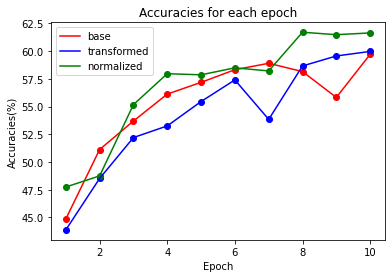

In [10]:
def compare_acc():
    acc_per_epoch_base = np.load('./logging/base.npy')
    acc_per_epoch_transformed = np.load('./logging/transformed.npy')
    acc_per_epoch_normalized = np.load('./logging/normalized.npy')
    epochs = np.array(range(1, 11))
    plt.title("Accuracies for each epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracies(%)")
    plt.plot(epochs, acc_per_epoch_base, color='red', label='base')
    plt.plot(epochs, acc_per_epoch_transformed, color='blue', label='transformed')
    plt.plot(epochs, acc_per_epoch_normalized, color='green', label='normalized')
    plt.scatter(epochs, acc_per_epoch_base, color='red')
    plt.scatter(epochs, acc_per_epoch_transformed, color='blue')
    plt.scatter(epochs, acc_per_epoch_normalized, color='green')
    plt.legend()
    plt.show()


compare_acc()

**Provide a brief discussion why the extra normalization and augmentation improves/harms the performance based on your result. (2P)**

I believe that data augmentation improves the generalization of the model and avoids data fitting, but increases the time consuming training and the iteration time needed to achieve the desired accuracy. Normalization, on the other hand, speeds up the convergence of the model and somewhat accelerates the training slowdown due to data augmentation.

### Task 2: Visualize the Activation Map

1. **Instantiate a pre-trained ResNet18 Apart from implementing your own neural networks, torchvision.models provides a bunch of often used network architectures with the pre-trained weights (usually pre-trained on ImageNet with classification task). Now we will first instantiate a ResNet-18 and print out its architecture.(1P)**
2. **Store the intermediate activation maps When you define your model.forward() function, you will have intermediate features after different layers, like the variable out in the code snippet below. Please extract intermediate activations for the pug.jpg provided with the sheet from at least 2 different layers (for instance, the out after conv1 and the out after conv3 below).(3P)**
3. **Visualize the Activation Maps Now visualize these activation maps you just got and report/discuss what you see. Most likely you will be facing at least one problem here, as the channel for the activation maps are some different numbers other than 1 (grayscale) or 3 (RGB), which you cannot directly use plt.imshow() to visualize. So you would need some Dimensionality Reduction techniques to proceed this task, for instance PCA, but you can do whatever you want. Even something like the mean value of the first 10 channels will be accepted, as soon as the visulization makes sense and you can explain it.(2P)**

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

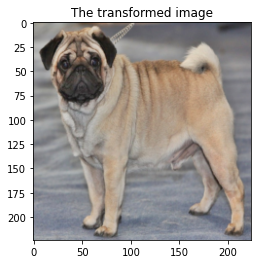

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


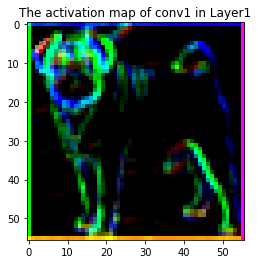

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


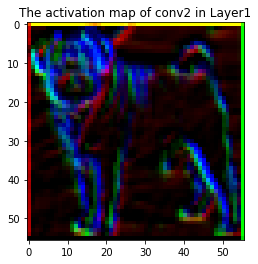

In [11]:
def show_tensor(tensor, title):
    if tensor.ndim == 4:
        temp = tensor.squeeze()
    else:
        temp = tensor
    plt.imshow(temp.cpu().permute(1, 2, 0))
    plt.title(title)
    plt.show()


def task_2():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    resNet = torchvision.models.resnet18(pretrained=True).eval().to(device)
    print(resNet)
    image = Image.open('pug.jpg')
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    X = transform(image).unsqueeze(dim=0).to(device)

    show_tensor(X.squeeze(), "The transformed image")
    activation_maps = []

    # define a hook function
    def hook(module, input, output):
        activation_maps.append(output)

    # register the forward hook in the layer1 conv1 and conv2
    resNet.layer1[0].conv1.register_forward_hook(hook)
    resNet.layer1[0].conv2.register_forward_hook(hook)
    output = resNet(X)

    # use PCA to reduce the dimensions of the channels
    def activation_map_pca(map, title):
        map1 = map.permute(0, 2, 3, 1).view(-1, 64).cpu().detach().numpy()
        pca = PCA(n_components=3)
        map1_reduce = torch.tensor(pca.fit_transform(map1)).view(1, 56, 56, 3).permute(0, 3, 1, 2)
        show_tensor(map1_reduce, title)

    activation_map_pca(activation_maps[0], "The activation map of conv1 in Layer1")
    activation_map_pca(activation_maps[1], "The activation map of conv2 in Layer1")
    pass


task_2()

4. **Plot both the activation map and the original image Show the activation map on top of our original image. And check whether this matches a human’s intuition - how would you recognize the given image? There might be one problem you will be facing, because the spatial resolutions of the activation map and the original image do not match. Hint: Image Re-sampling.**

After downscaling 64 channels to 3 channels and visualizing them by PCA, it can be found that the pixel points appear to be "categorical", i.e., certain feature pixels that are considered "important" by the model stand out. The activation maps extracted from Layer1's conv1 and conv2 are consistent with human intuition, i.e., the important pixels are concentrated at the edges or contours, which describe the shape of the object from an intuitive point of view.

### Task 3: Saliency Maps and Reading Materials

1. **Complete the saliency map function**

In [12]:
def preprocess(img, size=224):
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[None]),  # equivalent to unsqueeze()
    ])
    return transform(img)


def saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()

    # make a copy of the tensor and set X_var to require gradient for later visualization
    X_var = X.clone().detach()
    X_var.requires_grad = True
    y_var = y.clone().detach()
    saliency = None
    ############ your code here ############

    ##############################################################################
    # Implement this function. Perform a forward and backward pass through       #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores, and then compute the gradients with a backward pass.               #
    ##############################################################################
    output = model(X_var)
    score, Indices = torch.max(output, dim=1)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(output, y_var)
    loss.backward()
    saliency, _ = torch.max(torch.abs(X_var.grad), dim=1)
    ############ end of your code############
    return saliency

2. **Visualize the origianal image with the saliency maps together and provide a short discussion why would different ground truth labels with even the same input image would yield different saliency maps, for instance the catdog image with y = 243 (bull mastiff) and y = 285 (Egyptian cat).**

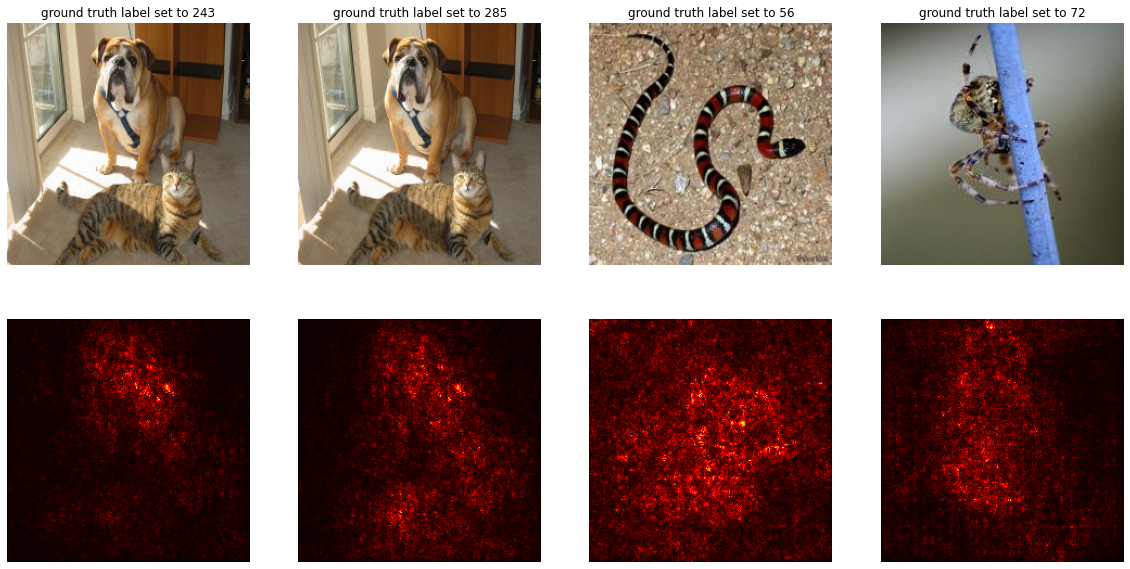

In [13]:
def show_saliency_maps():
    # device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    names = ['catdog_243.png', 'catdog_243.png', 'snake_56.png', 'spider_72.png']

    X = [np.array(Image.open(name).convert('RGB')) for name in names]
    y = [int(s.rsplit('_')[1].rsplit('.')[0]) for s in names]
    # intentionally change the label to a wrong one
    y[1] = 285
    model = torchvision.models.resnet18(pretrained=True).eval().to(device)
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0).to(device)
    y_tensor = torch.LongTensor(y).to(device)
    # Compute saliency maps for images in X
    saliency = saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.cpu().numpy()
    N = len(X)
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title('ground truth label set to {}'.format(y[i]))
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(20, 10)
    plt.show()
    pass


show_saliency_maps()

Even though the same input image is used, this results in the loss function giving different results due to the use of different ground truth, causing a shift in the important features considered by the model. In this case, when the label of the image is set to Egyptian cat, the importance of the pixel where the cat is located in the image clearly occurs.